# Predicting What Year a Subreddit Post Came From
---

### This notebook accomplishes the following:
---

Here we're playing with time!!! 

In [1]:
import numpy as np
import time
import pandas as pd
import nltk

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem.porter import PorterStemmer

In [2]:
poli_2012_df = pd.read_csv('../data/poli_dis_2012.csv')
poli_2020_df = pd.read_csv('../data/poli_dis_2020.csv')

In [3]:
poli_2012_df.columns

Index(['author', 'author_flair_css_class', 'author_flair_text', 'created_utc',
       'domain', 'full_link', 'id', 'is_self', 'media_embed', 'num_comments',
       'over_18', 'permalink', 'score', 'selftext', 'subreddit',
       'subreddit_id', 'thumbnail', 'title', 'url', 'author_created_utc',
       'author_fullname', 'edited', 'distinguished', 'year'],
      dtype='object')

In [4]:
poli_2012_df['id'].nunique()

4882

In [5]:
poli_2012_df['selftext']

0                                                     NaN
1       I used to consider myself a conservative until...
2       So what happens then? Raise the debt ceiling a...
3       ...Last year I mismanaged my funds and this ye...
4       Acccording to the Washington Post: \n\n80 mill...
                              ...                        
4877                                                  NaN
4878    I find it interesting that the media has reall...
4879    Here's an infographic giving a short backgroun...
4880    Radically. As in "roots", every radical will s...
4881    &gt; In Pennsylvania, the Republican-dominated...
Name: selftext, Length: 4882, dtype: object

In [6]:
poli_2020_df['id'].nunique()

5000

In [7]:
frames = [poli_2012_df, poli_2020_df]
master_df = pd.concat(frames)

In [8]:
master_df

,author,author_flair_css_class,author_flair_text,created_utc,domain,full_link,id,is_self,media_embed,num_comments,...,link_flair_template_id,link_flair_text,post_hint,preview,author_flair_background_color,author_flair_text_color,author_cakeday,banned_by,suggested_sort,author_flair_template_id
0,[deleted],NaN,NaN,1311796165,self.PoliticalDiscussion,https://www.reddit.com/r/PoliticalDiscussion/c...,j1g7n,True,{},5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,PareidoliaX,NaN,NaN,1311795743,self.PoliticalDiscussion,https://www.reddit.com/r/PoliticalDiscussion/c...,j1fzj,True,{},34,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,qerq,NaN,NaN,1311793404,self.PoliticalDiscussion,https://www.reddit.com/r/PoliticalDiscussion/c...,j1en6,True,{},14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,shamusoconner,NaN,NaN,1311792541,self.PoliticalDiscussion,https://www.reddit.com/r/PoliticalDiscussion/c...,j1e83,True,{},2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,[deleted],NaN,NaN,1311791793,self.PoliticalDiscussion,https://www.reddit.com/r/PoliticalDiscussion/c...,j1dtr,True,{},3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,WaterzGrace,NaN,NaN,1585331139,self.PoliticalDiscussion,https://www.reddit.com/r/PoliticalDiscussion/c...,fq1n07,True,NaN,3,...,969bd296-4091-11e6-8da9-0ef2cf42ad11,US Elections,NaN,NaN,NaN,NaN,NaN,NaN,confidence,NaN
4996,curious_thoughts_uk,NaN,NaN,1585330878,self.PoliticalDiscussion,https://www.reddit.com/r/PoliticalDiscussion/c...,fq1jqd,True,NaN,3,...,8ba3f5de-4092-11e6-b8ce-0ee96c7aff3d,US Politics,NaN,NaN,NaN,NaN,NaN,NaN,confidence,NaN
4997,patrick-thegamerdad,NaN,NaN,1585330173,self.PoliticalDiscussion,https://www.reddit.com/r/PoliticalDiscussion/c...,fq1azc,True,NaN,0,...,969bd296-4091-11e6-8da9-0ef2cf42ad11,US Elections,NaN,NaN,NaN,NaN,NaN,NaN,confidence,NaN
4998,steelbaxton,NaN,NaN,1585329457,self.PoliticalDiscussion,https://www.reddit.com/r/PoliticalDiscussion/c...,fq1263,True,NaN,1,...,8ba3f5de-4092-11e6-b8ce-0ee96c7aff3d,US Politics,NaN,NaN,NaN,NaN,NaN,NaN,confidence,NaN


In [9]:
text_df = master_df[['year', 'selftext']].copy()

In [10]:
text_df['selftext'].nunique()

4151

In [11]:
text_df.isnull().sum()

year          0
selftext    714
dtype: int64

In [13]:
text_df.replace(np.nan, "", regex=True, inplace=True)

In [14]:
text_df.isnull().sum()

year        0
selftext    0
dtype: int64

Finally, replace those nulls with empty strings.

In [15]:
master_df['year']

0       2012
1       2012
2       2012
3       2012
4       2012
        ... 
4995    2020
4996    2020
4997    2020
4998    2020
4999    2020
Name: year, Length: 9882, dtype: int64

In [16]:
#text_df['year'] = text_df['year'].map({2010:1,2020:0})

In [17]:
text_df['year'].value_counts(normalize=True)

2020    0.50597
2012    0.49403
Name: year, dtype: float64

In [18]:
text_df['selftext'][:5]

0                                                     
1    I used to consider myself a conservative until...
2    So what happens then? Raise the debt ceiling a...
3    ...Last year I mismanaged my funds and this ye...
4    Acccording to the Washington Post: \n\n80 mill...
Name: selftext, dtype: object

In [19]:
# lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def stem_stuff(line):
    tokenizer = RegexpTokenizer(r'\w+')
    line_tokens = tokenizer.tokenize(line.lower())
    stemmy = [stemmer.stem(word) for word in line_tokens]
    return stemmy

In [20]:
text_df.isnull().sum()

year        0
selftext    0
dtype: int64

In [21]:
text_df['selftext'] = text_df['selftext'].map(stem_stuff)
text_df['selftext'] = text_df['selftext'].apply(', '.join)

In [22]:
text_df['selftext'][:5]

0                                                     
1    i, use, to, consid, myself, a, conserv, until,...
2    so, what, happen, then, rais, the, debt, ceil,...
3    last, year, i, mismanag, my, fund, and, thi, y...
4    acccord, to, the, washington, post, 80, millio...
Name: selftext, dtype: object

In [23]:
X = text_df['selftext']
y = text_df['year']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state = 42, 
                                                    stratify = y)

In [25]:
X_train

2878                                                remov
2550    at, the, end, of, the, debat, they, went, to, ...
3395    if, you, ve, spoken, to, a, republican, in, th...
3390                                                remov
525                                                 remov
                              ...                        
2344                                                remov
2       so, what, happen, then, rais, the, debt, ceil,...
1417    and, evid, to, whi, michel, bachman, would, do...
1316                                                remov
3505    i, hear, a, lot, of, the, republican, presiden...
Name: selftext, Length: 7411, dtype: object

### Combine GridSearchCV and Bernoulli Naive Bayes model

In [45]:
pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words='english')),
    ('nb', BernoulliNB())
])

In [46]:
pipe_params = {
    #'cvec__max_features':[2000, 3000, 4000, 5000],
    #'cvec__min_df':[2, 3],
    #'cvec__max_df':[.9, .95],
    #'cvec__ngram_range':[(1, 1), (1, 2)]
}

In [47]:
gs = GridSearchCV(pipe, param_grid = pipe_params, cv = 5)

In [48]:
X_train

2878                                                remov
2550    at, the, end, of, the, debat, they, went, to, ...
3395    if, you, ve, spoken, to, a, republican, in, th...
3390                                                remov
525                                                 remov
                              ...                        
2344                                                remov
2       so, what, happen, then, rais, the, debt, ceil,...
1417    and, evid, to, whi, michel, bachman, would, do...
1316                                                remov
3505    i, hear, a, lot, of, the, republican, presiden...
Name: selftext, Length: 7411, dtype: object

In [49]:
gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)

print('train accuracy:', gs.score(X_train, y_train))
print('test accuracy:', gs.score(X_test, y_test))

0.8583180681097421
{}
train accuracy: 0.8638510322493591
test accuracy: 0.8514771347632537


In [50]:
type(X_test)

pandas.core.series.Series

In [51]:
preds = gs.predict(X_test)

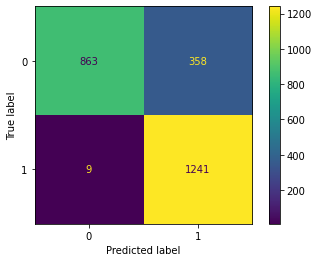

In [52]:
cm = confusion_matrix(y_test, preds)
tn, fp, fn, tp = cm.ravel()

ConfusionMatrixDisplay(cm).plot();

In [53]:
text_df

,year,selftext
0,2012,
1,2012,"i, use, to, consid, myself, a, conserv, until,..."
2,2012,"so, what, happen, then, rais, the, debt, ceil,..."
3,2012,"last, year, i, mismanag, my, fund, and, thi, y..."
4,2012,"acccord, to, the, washington, post, 80, millio..."
...,...,...
4995,2020,remov
4996,2020,remov
4997,2020,remov
4998,2020,remov


In [54]:
specificity = tn / (tn + fp)
print('specificity:', specificity)

specificity: 0.7067977067977068


### TFIDF Vectorizer

In [55]:
tvec = TfidfVectorizer()

In [56]:
X_train_df = pd.DataFrame(tvec.fit_transform(X_train).todense(),
                         columns = tvec.get_feature_names())

<AxesSubplot:>

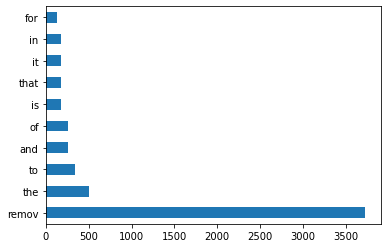

In [57]:
X_train_df.sum().sort_values(ascending=False).head(10).plot(kind='barh')

<AxesSubplot:>

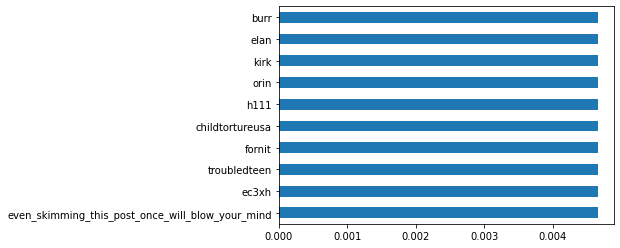

In [58]:
X_train_df.sum().sort_values(ascending=True).head(10).plot(kind='barh')

In [59]:
pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer(stop_words='english')),
    ('nb', MultinomialNB())
])

In [60]:
pipe_tvec_params = {
    #'tvec__max_features': [2000, 3000, 4000, 5000],
    #'tvec__stop_words': [None, 'english'],
    #'tvec__ngram_range': [(1, 1), (1, 2)]
}

In [61]:
gs_tvec = GridSearchCV(pipe_tvec, param_grid = pipe_tvec_params, cv=5)

In [62]:
gs_tvec.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(stop_words='english')),
                                       ('nb', MultinomialNB())]),
             param_grid={})

In [63]:
gs_tvec.best_params_

{}

In [64]:
gs_tvec.score(X_train, y_train)

0.9230873026582108

In [65]:
gs_tvec.score(X_test, y_test)

0.915418858761635

In [68]:
X_test

190                                                      
558                                                 remov
4261    make, sure, to, say, what, year, you, were, bo...
1089                                                remov
2762    i, m, not, tri, to, be, fun, sucker, or, anyth...
                              ...                        
2391                                                remov
875     i, m, a, liber, progress, and, i, don, t, shi,...
3584    note, when, i, say, liber, and, conserv, i, am...
3297                                                     
4575                                                remov
Name: selftext, Length: 2471, dtype: object

In [66]:
preds_tvec = gs_tvec.predict(X_test)

cm = confusion_matrix(y_test, preds_tvec)
tn, fp, fn, tp = cm.ravel()

specificity = tn / (tn + fp)
specificity

0.8370188370188371

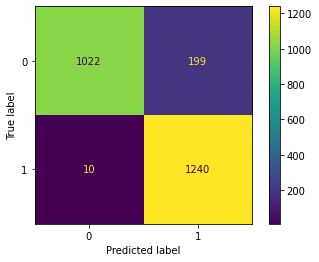

In [67]:
ConfusionMatrixDisplay(cm).plot();